In [48]:
# Khai báo thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import warnings
import seaborn as sns
#Các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM,Dropout,Dense #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
#kiểm tra độ chính xác của mô hình
from sklearn.metrics import mean_squared_error # do độ chính xác của mô hình dự đoán
from sklearn.metrics import r2_score #đo múc độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo phần trăm sai số tuyệt đối trung bình
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [49]:
# Kết nối với Google Drive
from google.colab import drive
drive.mount("/drive")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [50]:
df = pd.read_csv('/drive/MyDrive/ĐỒ ÁN VÀ THỰC TẬP/ĐỒ ÁN/data/city_temperature.csv')
df.head()

Region  Country State     City  Month  Day  Year  AvgTemperature
0  Africa  Algeria   NaN  Algiers      1    1  1995            64.2
1  Africa  Algeria   NaN  Algiers      1    2  1995            49.4
2  Africa  Algeria   NaN  Algiers      1    3  1995            48.8
3  Africa  Algeria   NaN  Algiers      1    4  1995            46.4
4  Africa  Algeria   NaN  Algiers      1    5  1995            47.9

In [51]:
df = df.drop('State', axis=1)

In [52]:
df =df[ (df['Year'] != 200) & (df['Year'] != 201) & (df['Day'] != 0) ]

In [53]:
df = df[df['AvgTemperature']>-80]

In [54]:
data = df[df['Country'] == 'China']

In [55]:
bj = data[data['City'] == 'Beijing']

In [56]:
bj = data.loc[data['City'] == 'Beijing',['Month','Day','Year','AvgTemperature']].reset_index(drop=True)
bj.head(3)

Month  Day  Year  AvgTemperature
0      1    1  1995            28.0
1      1    2  1995            29.0
2      1    3  1995            29.9

In [57]:
bj['Date'] = bj[['Year','Month','Day']].apply(lambda row:'-'.join([str(row['Year']),str(row['Month']),str(row['Day'])]),axis=1)
bj['Date'] = pd.to_datetime(bj['Date'])
bj = bj.drop(columns=['Month','Day','Year']).set_index('Date')
bj.head(3)

AvgTemperature
Date                      
1995-01-01            28.0
1995-01-02            29.0
1995-01-03            29.9

In [58]:
test_bj = bj[bj.index>'2019']
train_bj = bj[bj.index<'2019']

In [59]:
scaler = MinMaxScaler()
train_bj = scaler.fit_transform(train_bj)
test_bj = scaler.transform(test_bj)

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
time_steps = 20
features = 1

train_gen = TimeseriesGenerator(train_bj,train_bj,time_steps,batch_size=32)
test_gen = TimeseriesGenerator(test_bj,test_bj,time_steps,batch_size=32)


In [61]:
model = Sequential()
model.add(LSTM(64,activation='relu',input_shape=(time_steps,features),return_sequences=True))
model.add(LSTM(32,activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(optimizer='adam',loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 64)            16896     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
early_stop = EarlyStopping(patience=5)

In [63]:
model.fit(x=train_gen,epochs=20,callbacks=[early_stop],validation_data=test_gen)

Epoch 1/20
273/273 [==============================] - 11s 31ms/step - loss: 0.0293 - val_loss: 0.0065
Epoch 2/20
273/273 [==============================] - 5s 18ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 3/20
273/273 [==============================] - 6s 22ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 4/20
273/273 [==============================] - 4s 16ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 5/20
273/273 [==============================] - 5s 18ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 6/20
273/273 [==============================] - 6s 22ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 7/20
273/273 [==============================] - 5s 18ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 8/20
273/273 [==============================] - 6s 22ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 9/20
273/273 [==============================] - 4s 16ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 10/20
273/273 [==============================] - 5s 19ms/step - loss: 0.0030 - val_l

In [64]:
predict = model.predict(test_gen)
test_targets = test_gen.targets[test_gen.start_index:test_gen.end_index+1]
predict = scaler.inverse_transform(predict).ravel()
test_targets = scaler.inverse_transform(test_targets).ravel()

15/15 [==============================] - 1s 9ms/step


In [65]:
rmse_lstm=(np.sqrt(mean_squared_error(predict,test_targets)))

In [66]:
print('The RMSE Score is:',rmse_lstm)

The RMSE Score is: 4.92952617606747


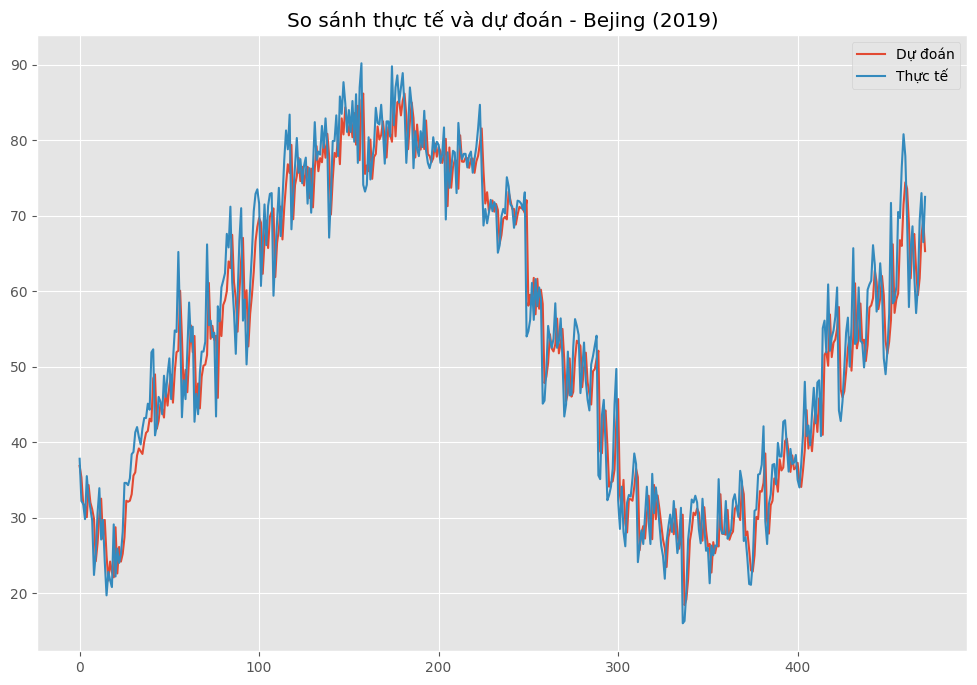

In [67]:
from sklearn.metrics import mean_squared_error
_,ax=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(x=range(len(predict)),y=predict,ax=ax,label='Dự đoán')
sns.lineplot(x=range(len(test_targets)),y=test_targets,ax=ax,label='Thực tế')
plt.legend()
_=plt.title('So sánh thực tế và dự đoán - Bejing (2019)')

In [68]:
import datetime
data = bj.iloc[-time_steps:].to_numpy()
data = scaler.transform(data)

data = np.expand_dims(data,0)

date = bj.index[-1]
date_store = bj.iloc[-time_steps:].index.to_list()

forecasts=10
for i in range(forecasts):
    predicted = model.predict(data[:,-20:,:])
    date = date+datetime.timedelta(days=1)
    data = np.append(data,[predicted],axis=1)
    date_store.append(date)

data = scaler.inverse_transform(data.reshape(1,-1))
forecast_df = pd.DataFrame(index=date_store[time_steps-1:],data={'AvgTemperature':data.ravel()[time_steps-1:]})

1/1 [==============================] - 0s 20ms/step


In [69]:
print(forecast_df)

            AvgTemperature
2020-05-13       72.500000
2020-05-14       70.644434
2020-05-15       68.745414
2020-05-16       68.131726
2020-05-17       67.855498
2020-05-18       67.651120
2020-05-19       67.468436
2020-05-20       67.275819
2020-05-21       67.061253
2020-05-22       66.810252
2020-05-23       66.544500


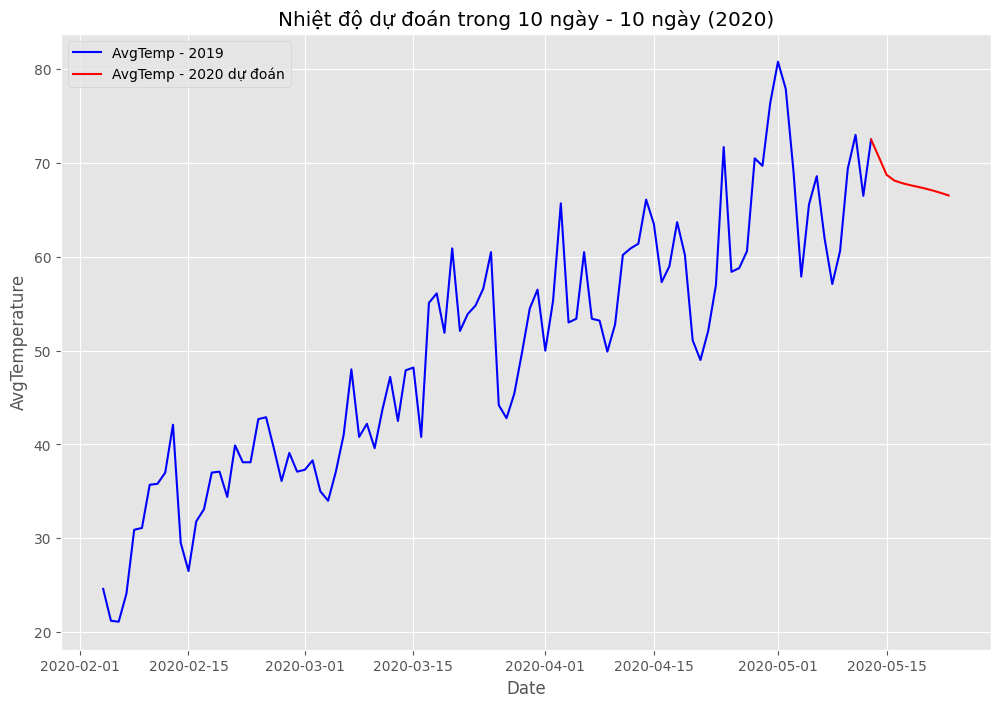

In [70]:
_,ax=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(data=bj.iloc[-100:,:],y='AvgTemperature',x=bj.iloc[-100:,:].index,color='blue',ax=ax,label='AvgTemp - 2019 ')
sns.lineplot(data=forecast_df,y='AvgTemperature',x=forecast_df.index,color='red',ax=ax,label= 'AvgTemp - 2020 dự đoán')
_=plt.title(f'Nhiệt độ dự đoán trong 10 ngày - {forecasts} ngày (2020)')